In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
#from sklearn.pipeline import Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# TensorFlow ≥2.0 is required
import tensorflow_addons as tfa
import tensorflow as tf
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras import layers

#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values
# Custom utils
from utils.utils_ml import *
from utils.utils_plot import *
from utils.utils_data import *

In [2]:
# Define paths
config = dotenv_values(".env")

In [3]:
PATH_ERA5 = config['PATH_ERA5']
PATH_EOBS = config['PATH_EOBS']

In [4]:
# Paths
#DATADIR = '/storage/workspaces/giub_hydro/hydro/data/'
#DATADIR = os.path.join(os.getcwd(), '..', 'data')

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]
YY_VAL = '2014'
G = 9.80665 

In [5]:
sel_levels = [500, 850, 1000]

In [6]:
# Read precipitation ERA5
pr = get_era5_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END)

Extracting data for the period 1979-01-01 - 2020-12-31


In [7]:
lon_pr=pr.lon
lat_pr=pr.lat
time_pr = pr.time

In [8]:
#check dimensions
pr.dims

Frozen({'time': 15341, 'lon': 71, 'lat': 51})

In [21]:
pr_Datarray = xr.DataArray(pr.tp)

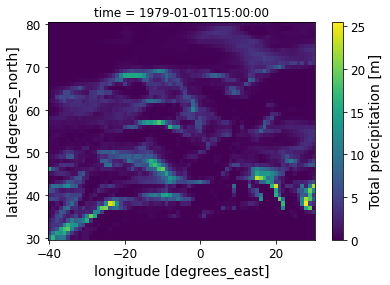

In [12]:
pr_Datarray[0,:,:].plot()

In [13]:
# Define precipitation extremes using the 95th
th95 = 0.95
pr95 = precip_exceedance_xarray(pr, th95)

In [14]:
# Load gridded 1x1 data
z = get_era5_data(DATADIR + '/ERA5/geopotential/grid1/*.nc', DATE_START, DATE_END)
z = z.sel(level=sel_levels)
# Get Z in geopotential height (m)
z.z.values = z.z.values/G

Extracting data for the period 1979-01-01 - 2020-12-31


In [18]:
# select the same coordinates values than precipitation
z_new = z.sel(lon=slice(min(lon_pr), max(lon_pr)))

In [19]:
z_new.dims

Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})

In [20]:
# temperature
t2m = get_era5_data(DATADIR + '/ERA5/temperature/grid1/Grid1_Daymean_era5_T2M_EU_19790101-20211231.nc', DATE_START, DATE_END)
t2m['time'] = pd.DatetimeIndex(t2m.time.dt.date)
# select the same coordinates values than precipitation
t2m_new = t2m.sel(lon=slice(min(lon_pr), max(lon_pr)))
t2m_1lev = t2m_new.expand_dims('level', axis=1)

Extracting data for the period 1979-01-01 - 2020-12-31


In [21]:
# relative humidity
rh = get_era5_data(DATADIR + '/ERA5/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END)
rh['time'] = pd.DatetimeIndex(rh.time.dt.date) # need to have the same time-format
rh = rh.sel(level=sel_levels)

Extracting data for the period 1979-01-01 - 2020-12-31


In [22]:
rh_new = rh.sel(lon=slice(min(lon_pr), max(lon_pr)))

In [23]:
# Wind components 850hpa
u850 = get_era5_data(DATADIR + '/ERA5/U_wind/day_grid1/*.nc', DATE_START, DATE_END)
u850['time'] = pd.DatetimeIndex(u850.time.dt.date)
u850_new = u850.sel(lon=slice(min(lon_pr), max(lon_pr)))
v850 = get_era5_data(DATADIR + '/ERA5/V_wind/day_grid1/*.nc', DATE_START, DATE_END)
v850['time'] = pd.DatetimeIndex(v850.time.dt.date)
v850_new = v850.sel(lon=slice(min(lon_pr), max(lon_pr)))

Extracting data for the period 1979-01-01 - 2020-12-31
Extracting data for the period 1979-01-01 - 2020-12-31


In [24]:
# checking dimensions
print('dimension of z',z_new.dims)
print('dimension of t2m:',t2m_new.dims)
print('dimension of rh:',rh_new.dims)


dimension of z Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})
dimension of t2m: Frozen({'time': 15341, 'lon': 71, 'lat': 51})
dimension of rh: Frozen({'time': 15341, 'lon': 71, 'lat': 51, 'level': 3})


In [25]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
# Then we need a dictionary for all the variables and levels we want to extract from the dataset
#dic = OrderedDict({'z': 3, 'T2MMEAN':None, 'r':3})
# For now, I won't use wind (it takes too long...now)
bs = 32
dic = {'z': sel_levels,
        'T2MMEAN': None,
         'r': sel_levels}

In [27]:
# prepare the data
# For the data generator all variables have to be merged into a single dataset.
datasets = [z_new, t2m_new, rh_new]
ds = xr.merge(datasets)

In [28]:
# Split into training and test, then I will use DataGenerator class to get the validation
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]),
                             '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]),
                            '{}-12-31'.format(YY_TEST[1])))


In [29]:
ds_test.dims

Frozen({'lat': 51, 'time': 1827, 'lon': 71, 'level': 3})

In [30]:
# define lead time 5days
lead_time = 5

In [31]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator_extended(ds_train.sel(time=slice('1979', '2014')), dic, lead_time, batch_size=bs, load=True)

Loading data into RAM


In [32]:
# Create a validation. Use the train mean and std for validation as well. And suffle
dg_val = DataGenerator_extended(ds_train.sel(time=slice('2015', '2015')), dic,lead_time, batch_size=bs,  mean=dg_train.mean, std=dg_train.std, load=True)

Loading data into RAM


In [33]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator_extended(ds_test, dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)

Loading data into RAM


In [34]:
# Prepare the data
X_train = xr.DataArray(dg_train.data)
X_val = xr.DataArray(dg_val.data)
X_test = xr.DataArray(dg_test.data)

In [35]:
X_train_input = np.array(X_train)
X_val_input = np.array(X_val)
X_test_input = np.array(X_test)

In [36]:
Y_train, Y_val, Y_test = get_Y_sets(pr_Datarray, YY_TRAIN, YY_VAL, YY_TEST)
# Reshaping data
Y_train_input = Y_train.reshape(Y_train.shape[0],Y_train.shape[1]*Y_train.shape[2])
Y_test_input = Y_test.reshape(Y_test.shape[0],Y_test.shape[1]*Y_test.shape[2])
Y_val_input = Y_val.reshape(Y_val.shape[0],Y_val.shape[1]*Y_val.shape[2])

In [37]:
# Same for extreme daata
Y_ex_train, Y_ex_val, Y_ex_test = get_Y_sets(pr95, YY_TRAIN, YY_VAL, YY_TEST)

In [38]:
yshape= Y_train.shape
yshape

(13149, 51, 71)

In [39]:
# Simple model -extreme case

In [40]:
m0 = keras.models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    #layers.MaxPooling2D(pool_size=2),
    layers.Dense(1, activation='sigmoid')])

2022-01-31 17:56:59.642513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 17:57:02.541088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10411 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [41]:
m0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 51, 71, 16)        1024      
                                                                 
 batch_normalization (BatchN  (None, 51, 71, 16)       64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 51, 71, 1)         17        
                                                                 
Total params: 1,105
Trainable params: 1,073
Non-trainable params: 32
_________________________________________________________________


In [42]:
#for layer in m0.layers:
#    print(layer.get_output_at(0).get_shape().as_list())

In [43]:
#m0.compile(optimizer=keras.optimizers.Adam(),
#              loss=keras.losses.BinaryCrossentropy(from_logits=True), # default from_logits=False
#              metrics=[keras.metrics.BinaryAccuracy()])
m0.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [44]:
h0= m0.fit(X_train_input, 
                Y_ex_train,
                         epochs=10,
                         validation_data=(X_val_input, Y_ex_val),
                         shuffle=True)

Epoch 1/10


2022-01-31 17:57:10.354508: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


411/411 [==============================] - 14s 7ms/step - loss: 0.3636 - accuracy: 0.8949 - val_loss: 0.2199 - val_accuracy: 0.9456
Epoch 2/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1967 - accuracy: 0.9504 - val_loss: 0.2110 - val_accuracy: 0.9456
Epoch 3/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1955 - accuracy: 0.9504 - val_loss: 0.2099 - val_accuracy: 0.9456
Epoch 4/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1951 - accuracy: 0.9504 - val_loss: 0.2094 - val_accuracy: 0.9456
Epoch 5/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1950 - accuracy: 0.9504 - val_loss: 0.2096 - val_accuracy: 0.9456
Epoch 6/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1949 - accuracy: 0.9504 - val_loss: 0.2089 - val_accuracy: 0.9456
Epoch 7/10
411/411 [==============================] - 2s 6ms/step - loss: 0.1948 - accuracy: 0.9504 - val_loss: 0.2086 - val_accuracy: 0.9456
Epoch 8/10
411/4

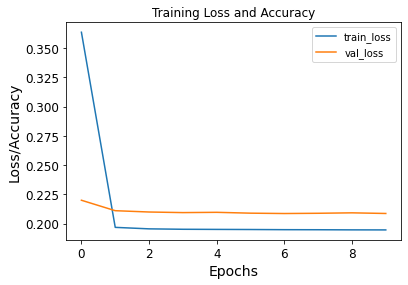

In [45]:
plot_hist(h0)

### Trying the whole distribution (not extremes)

In [46]:
# model 1 (adapted from Pascal, but this is not for extremes)
# ANN using timeseries to predict precipitation
m = keras.models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.SpatialDropout2D(0.2),
    layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2),
    layers.SpatialDropout2D(0.2),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(yshape[1]*yshape[2], activation='relu') #Not sure about this Dense layer though
])
m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 51, 71, 16)        1024      
                                                                 
 batch_normalization_1 (Batc  (None, 51, 71, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 35, 16)       0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 25, 35, 16)       0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 35, 16)        2320      
                                                      

In [47]:
m.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [48]:
history = m.fit(X_train_input, 
                Y_train_input,
                         epochs=10,
                         validation_data=(X_val_input, Y_val_input),
                         shuffle=True)

Epoch 1/10
411/411 [==============================] - 5s 8ms/step - loss: 20.5957 - mae: 2.2190 - mse: 20.5957 - val_loss: 20.4892 - val_mae: 2.3579 - val_mse: 20.4892
Epoch 2/10
411/411 [==============================] - 3s 7ms/step - loss: 17.9902 - mae: 2.1927 - mse: 17.9902 - val_loss: 17.5777 - val_mae: 2.2603 - val_mse: 17.5777
Epoch 3/10
411/411 [==============================] - 3s 7ms/step - loss: 15.8722 - mae: 2.1582 - mse: 15.8722 - val_loss: 15.9670 - val_mae: 2.1639 - val_mse: 15.9670
Epoch 4/10
411/411 [==============================] - 3s 7ms/step - loss: 15.1468 - mae: 2.1366 - mse: 15.1468 - val_loss: 15.3702 - val_mae: 2.0561 - val_mse: 15.3702
Epoch 5/10
411/411 [==============================] - 3s 7ms/step - loss: 14.8495 - mae: 2.1075 - mse: 14.8495 - val_loss: 15.0141 - val_mae: 2.0104 - val_mse: 15.0141
Epoch 6/10
411/411 [==============================] - 3s 7ms/step - loss: 14.6734 - mae: 2.0908 - mse: 14.6734 - val_loss: 14.8156 - val_mae: 2.0173 - val_mse: 

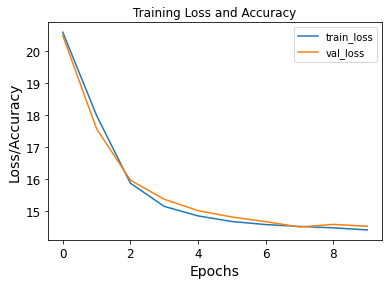

In [49]:
plot_hist(history)

In [50]:
# make predictions
prediction = m.predict(X_test_input)

In [51]:
X_test_input.shape

(1827, 51, 71, 7)

In [52]:
prediction.shape
yshape[1]

51

In [53]:
# reshape
pr_predicted = prediction.reshape(X_test_input.shape[0],yshape[1],yshape[2])

In [54]:
pr_predicted.shape
pr_pred = xr.DataArray(pr_predicted, coords=[ds_test.time, ds_test.lat, ds_test.lon],
    dims=["time",'lat','lon'])
pr_pred.dims

('time', 'lat', 'lon')

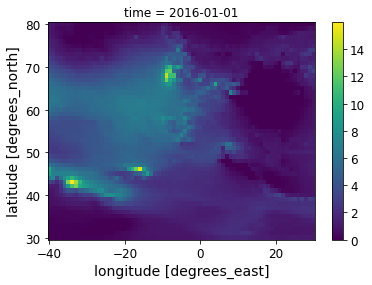

In [55]:
pr_pred[0,:,:].plot()

In [56]:
 # Load country outlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [57]:
Y_test.shape

(1827, 51, 71)

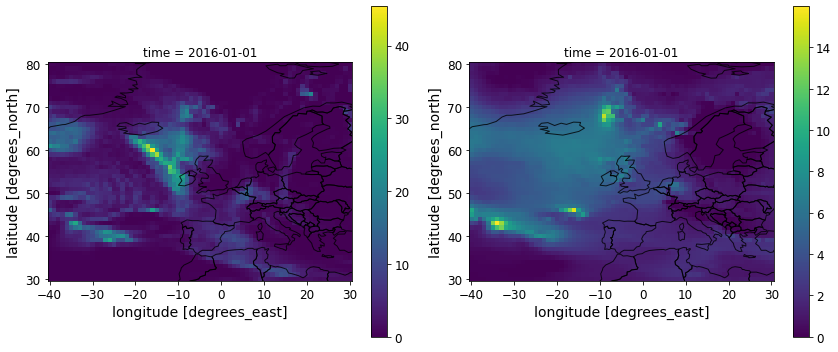

In [58]:
# truth (test)
fig, axs = plt.subplots(1, 2,figsize=(12,5))
Y_test = xr.DataArray(Y_test, coords=[ds_test.time, ds_test.lat, ds_test.lon],
     dims=["time",'lat','lon'])
Y_test[0,:,:].plot(ax = axs[0])
world.plot(ax = axs[0], alpha = 0.8, facecolor = 'none', lw = 1)

# prediction
pr_pred[0,:,:].plot(ax = axs[1])
world.plot(ax = axs[1], alpha = 0.8, facecolor = 'none', lw = 1)
fig.tight_layout()

In [ ]:
# CNN + LSTM for non-extremes(still working on this...) 

In [92]:
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense,LSTM,Conv2D, BatchNormalization,Flatten, MaxPooling2D
from keras.layers import Conv2DTranspose,Concatenate,UpSampling2D,Cropping2D
from keras.layers import Input, Lambda, Reshape, Dropout, Activation

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [94]:
X_train[:,0:48,0:64].shape

(13149, 48, 64, 7)

In [59]:
# Change the dimensions # just remove 3x3 grids
X_train_input = X_train_input[:,0:48,0:68,]
Y_train_input = Y_train_input[:,0:48,0:68,]
X_val_input = X_val_input[:,0:48,0:68,]
Y_val_input = Y_val_input[:,0:48,0:68,]
X_test_input = X_test_input[:,0:48,0:68,]
#Y_test = Y_test[:,0:48,0:68,]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [248]:
Y_val_input.shape

(365, 48, 68)

In [266]:
model = Sequential()
model.add(Input(shape=X_train_input.shape[1:]))
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Reshape((12*17, 16)))  # I need to reshape, as the LSTM expect a tensor 2D
model.add(LSTM(units=16,return_sequences=True))
#model.add(Dense(12))
#model.add(Flatten())
model.add(Reshape((12, 17, 16)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (1,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
#model.add(Reshape((48*68,1)))


In [267]:
model.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_185 (Conv2D)         (None, 48, 68, 16)        1024      
                                                                 
 max_pooling2d_161 (MaxPooli  (None, 24, 34, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_129 (Ba  (None, 24, 34, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_186 (Conv2D)         (None, 24, 34, 16)        2320      
                                                                 
 max_pooling2d_162 (MaxPooli  (None, 12, 17, 16)       0         
 ng2D)                                                           
                                                     

In [268]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [269]:
l_hist = model.fit(X_train_input, Y_train_input, epochs=10, validation_data=(X_val_input, Y_val_input), shuffle=True)

Epoch 1/10
411/411 [==============================] - 9s 14ms/step - loss: 18.3415 - mae: 2.5083 - mse: 18.3415 - val_loss: 19.6599 - val_mae: 2.5375 - val_mse: 19.6599
Epoch 2/10
411/411 [==============================] - 5s 13ms/step - loss: 17.3818 - mae: 2.4225 - mse: 17.3818 - val_loss: 18.9296 - val_mae: 2.4713 - val_mse: 18.9296
Epoch 3/10
411/411 [==============================] - 5s 13ms/step - loss: 16.8977 - mae: 2.3615 - mse: 16.8977 - val_loss: 18.4557 - val_mae: 2.4389 - val_mse: 18.4557
Epoch 4/10
411/411 [==============================] - 5s 13ms/step - loss: 16.5472 - mae: 2.3166 - mse: 16.5472 - val_loss: 18.2282 - val_mae: 2.2937 - val_mse: 18.2282
Epoch 5/10
411/411 [==============================] - 5s 13ms/step - loss: 16.2914 - mae: 2.2857 - mse: 16.2915 - val_loss: 17.8932 - val_mae: 2.3398 - val_mse: 17.8932
Epoch 6/10
411/411 [==============================] - 5s 13ms/step - loss: 16.0881 - mae: 2.2640 - mse: 16.0881 - val_loss: 17.7571 - val_mae: 2.2525 - val

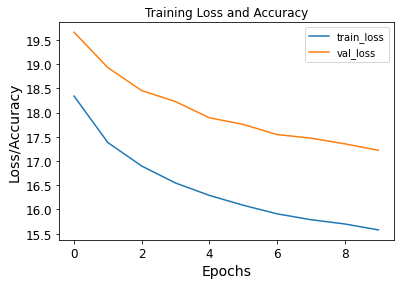

In [270]:
plot_hist(l_hist)

In [ ]:
# Try another archicteture